In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.dates import date2num, DateFormatter
from scipy.signal import savgol_filter as smooth
from scipy.signal import argrelextrema as extrema
from mpl_finance import candlestick_ohlc

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from datetime import datetime

from sklearn.preprocessing import KBinsDiscretizer, RobustScaler
from sklearn.preprocessing import FunctionTransformer

from category_encoders.woe import WOEEncoder as WoE
from sklearn.pipeline import make_pipeline

import stumpy

import warnings
#warnings.simplefilter("ignore", UserWarning)

import bt

from utils import rsi, basic_features, get_data, candle_counts, bindicators, mac_target, smooth_target

import gc; gc.enable()

In [2]:
df = get_data('BCHARTS-BITSTAMPUSD.csv')

In [4]:
df = basic_features(df, 12, 26)

In [5]:
df = candle_counts(df)

In [6]:
df['RSI'] = rsi(df, 14)

In [7]:
df = bindicators(df)

In [8]:
df = df.fillna(0)

In [9]:
df.head()

,date,Open,High,Low,Close,Volume (BTC),Volume (Currency),slope12,slope26,acc12,...,Spread_OC,color,region,region_len,sgn_region_len,RSI,RSI>70,RSI<30,RSI<20,MA12>MA26
index,,,,,,,,,,,,,,,,,,,,,
2016-12-31,736329.0,959.54,966.37,944.11,966.30,4162.921299,3.978648e+06,0.0,0.0,0.0,...,6.76,1,1,5,5,0.0,0.0,0.0,0.0,0.0
2017-01-01,736330.0,966.34,1005.00,960.53,997.75,6850.593309,6.764742e+06,0.0,0.0,0.0,...,31.41,1,1,5,5,0.0,0.0,0.0,0.0,0.0
2017-01-02,736331.0,997.75,1032.00,990.01,1012.54,8167.381030,8.273577e+06,0.0,0.0,0.0,...,14.79,1,1,5,5,0.0,0.0,0.0,0.0,0.0
2017-01-03,736332.0,1011.44,1039.00,999.99,1035.24,9089.658025,9.276500e+06,0.0,0.0,0.0,...,23.80,1,1,5,5,0.0,0.0,0.0,0.0,0.0
2017-01-04,736333.0,1035.51,1139.89,1028.56,1114.92,21562.456972,2.346964e+07,0.0,0.0,0.0,...,79.41,1,1,5,5,0.0,0.0,0.0,0.0,0.0


In [10]:
window = 26
matrix = stumpy.stump(df['2017':]['Close'], m=window)

In [11]:
peaks = extrema(matrix[:,0], np.greater, order = 10)[0].tolist()

In [12]:
# plt.figure(figsize=(20,8))
# plt.plot(matrix[:,0])

In [13]:
df, signal_df = mac_target(df, 12, 26)

In [14]:
df, smoothsig = smooth_target(df, 12)


In [15]:
df.Smooth.head()

index
2016-12-31    1034.781789
2017-01-01    1019.647208
2017-01-02    1004.512627
2017-01-03     989.378047
2017-01-04     974.243466
Name: Smooth, dtype: float64

In [16]:
signal_df.head()

,signal,short_mav,long_mav,positions
index,,,,
2016-12-31,0.0,966.300000,966.300000,NaN
2017-01-01,0.0,982.025000,982.025000,0.0
2017-01-02,0.0,992.196667,992.196667,0.0
2017-01-03,0.0,1002.957500,1002.957500,0.0
2017-01-04,0.0,1025.350000,1025.350000,0.0


In [17]:
smoothsig.head()

,signal,Smooth,positions
index,,,
2016-12-31,0.0,1034.781789,NaN
2017-01-01,0.0,1019.647208,0.0
2017-01-02,0.0,1004.512627,0.0
2017-01-03,0.0,989.378047,0.0
2017-01-04,0.0,974.243466,0.0


C:\Users\Brandon.Paralititan\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


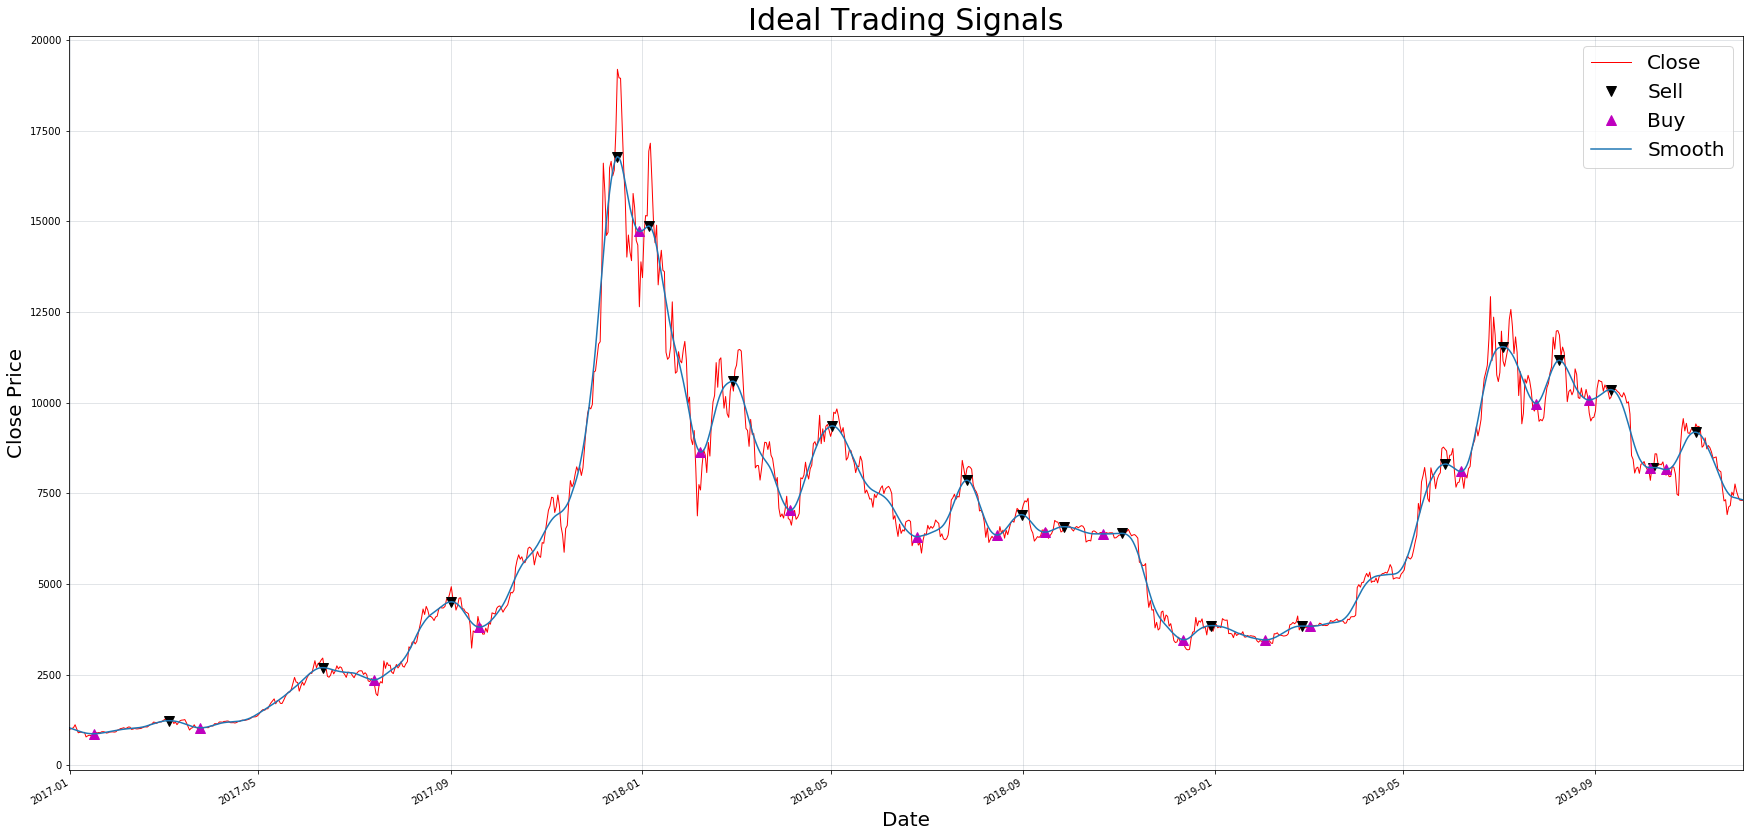

In [18]:
fig = plt.figure(figsize = (30,15))
plt1 = fig.add_subplot(111, ylabel = 'Close Price')

# plt1.plot(signal_df.index, signal_df.short_mav, color = 'green', linewidth = 1.0, linestyle = "--", label = "Short MAV")
# plt1.plot(signal_df.index, signal_df.long_mav, color = 'blue', linewidth = 1.0, linestyle = ":", label = "Long MAV")
plt1.plot(df.index, df.Close, color = 'red', label = "Close", linewidth = 1.0)

# plt1.plot(signal_df.short_mav[signal_df.positions == -1.0].index, signal_df.short_mav[signal_df.positions == -1], 'v', markersize = 10, color = 'k')
# plt1.plot(signal_df.short_mav[signal_df.positions == 1.0].index, signal_df.short_mav[signal_df.positions == 1], '^', markersize = 10, color = 'm')
plt1.plot(smoothsig.Smooth[smoothsig.signal == -1.0].index, smoothsig.Smooth[smoothsig.signal == -1.0], 'v', markersize = 10, color = 'k', label = 'Sell')
plt1.plot(smoothsig.Smooth[smoothsig.signal == 1.0].index, smoothsig.Smooth[smoothsig.signal == 1], '^', markersize = 10, color = 'm', label = 'Buy')

df['Smooth'].plot(figsize=(30,15))
#(20000*df['MAC_TARGET']).plot(figsize=(30,15))
#(20000*df['SMOOTH_TARGET']).plot(figsize=(30,15))
plt.title('Ideal Trading Signals', size = 30)
plt.xlabel('Date', size = 20)
plt.ylabel('Close Price', size = 20)
plt.legend(fontsize = 20)
plt.grid(alpha = 0.25, color = 'slategray')
plt.savefig('smooth.jpg', bbox_inches = 'tight')
plt.show()


In [19]:
gc.collect()

66941

In [20]:
#daily = daily.drop(daily.index[0:2])
#daily['TARGET'].replace(0, np.NaN, inplace=True)

In [21]:
df.head(21).append(df.tail())

,date,Open,High,Low,Close,Volume (BTC),Volume (Currency),slope12,slope26,acc12,...,region,region_len,sgn_region_len,RSI,RSI>70,RSI<30,RSI<20,MA12>MA26,MAC_TARGET,SMOOTH_TARGET
index,,,,,,,,,,,,,,,,,,,,,
2016-12-31,736329.0,959.54,966.37,944.11,966.30,4162.921299,3.978648e+06,0.000000,0.000000,0.000000,...,1,5,5,0.000000,0.0,0.0,0.0,0.0,1,1
2017-01-01,736330.0,966.34,1005.00,960.53,997.75,6850.593309,6.764742e+06,0.000000,0.000000,0.000000,...,1,5,5,0.000000,0.0,0.0,0.0,0.0,1,1
2017-01-02,736331.0,997.75,1032.00,990.01,1012.54,8167.381030,8.273577e+06,0.000000,0.000000,0.000000,...,1,5,5,0.000000,0.0,0.0,0.0,0.0,1,1
2017-01-03,736332.0,1011.44,1039.00,999.99,1035.24,9089.658025,9.276500e+06,0.000000,0.000000,0.000000,...,1,5,5,0.000000,0.0,0.0,0.0,0.0,1,1
2017-01-04,736333.0,1035.51,1139.89,1028.56,1114.92,21562.456972,2.346964e+07,0.000000,0.000000,0.000000,...,1,5,5,0.000000,0.0,0.0,0.0,0.0,1,1
2017-01-05,736334.0,1114.38,1136.72,885.41,1004.74,36018.861120,3.621140e+07,0.000000,0.000000,0.000000,...,2,2,-2,0.000000,0.0,0.0,0.0,0.0,1,1
2017-01-06,736335.0,1004.73,1026.99,871.00,893.89,27916.703099,2.552326e+07,0.000000,0.000000,0.000000,...,2,2,-2,0.000000,0.0,0.0,0.0,0.0,1,1
2017-01-07,736336.0,894.02,907.05,812.28,906.20,20401.113591,1.762431e+07,0.000000,0.000000,0.000000,...,3,2,2,0.000000,0.0,0.0,0.0,0.0,1,1
2017-01-08,736337.0,906.20,941.81,881.30,909.75,8937.492708,8.168170e+06,0.000000,0.000000,0.000000,...,3,2,2,0.000000,0.0,0.0,0.0,0.0,1,1


In [22]:
train = df[df.year<2019]
test = df['2019']

In [23]:
def stringify(df):
    return df.astype(str)

In [24]:
lr = LogisticRegression(solver = 'lbfgs', max_iter = 300)
_bin = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='quantile')
objectify = FunctionTransformer(func=stringify, validate=False)
woe = WoE()
#target = TE()
pipe = make_pipeline(_bin, objectify, woe, lr)

In [25]:
used_cols = [c for c in df.columns.tolist() if c not in ['target_region','MAC_TARGET''SMOOTH_TARGET', 'year', 'month', 'day', 'dow', 'date', 'Open', 'High', 'Close', 'Low', 'Smooth', 'Spread_HL', 'Spread_OC']]
#X, y = test[used_cols], test['SMOOTH_TARGET']
X, y = df[used_cols], df['SMOOTH_TARGET']

scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

C:\Users\Brandon.Paralititan\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 19 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
C:\Users\Brandon.Paralititan\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 21 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
C:\Users\Brandon.Paralititan\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 22 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
C:\Users\Brandon.Paralititan\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 24 are remove

0.8108745942623259 +/- 0.06239400425237606


C:\Users\Brandon.Paralititan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Brandon.Paralititan\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 19 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
C:\Users\Brandon.Paralititan\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 21 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
C:\Users\Brandon.Paralititan\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 22 are removed. Consider decreasing the number of bins.
  'decreasin

In [26]:
#smooth w/ train/test         0.8198250202664464 +/- 0.02940619697328976
#smooth w/o train/test        0.8107685964662406 +/- 0.06250655281367291
#mac w/ train/test            0.7475470851254824 +/- 0.12897383892473865

In [27]:
pipe.fit(X, y)
y_pred = pipe.predict(df[used_cols])

C:\Users\Brandon.Paralititan\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 19 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
C:\Users\Brandon.Paralititan\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 21 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
C:\Users\Brandon.Paralititan\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 22 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
C:\Users\Brandon.Paralititan\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 24 are remove

In [28]:
df['PRED'] = y_pred

In [29]:
df.to_csv('project_data.csv')

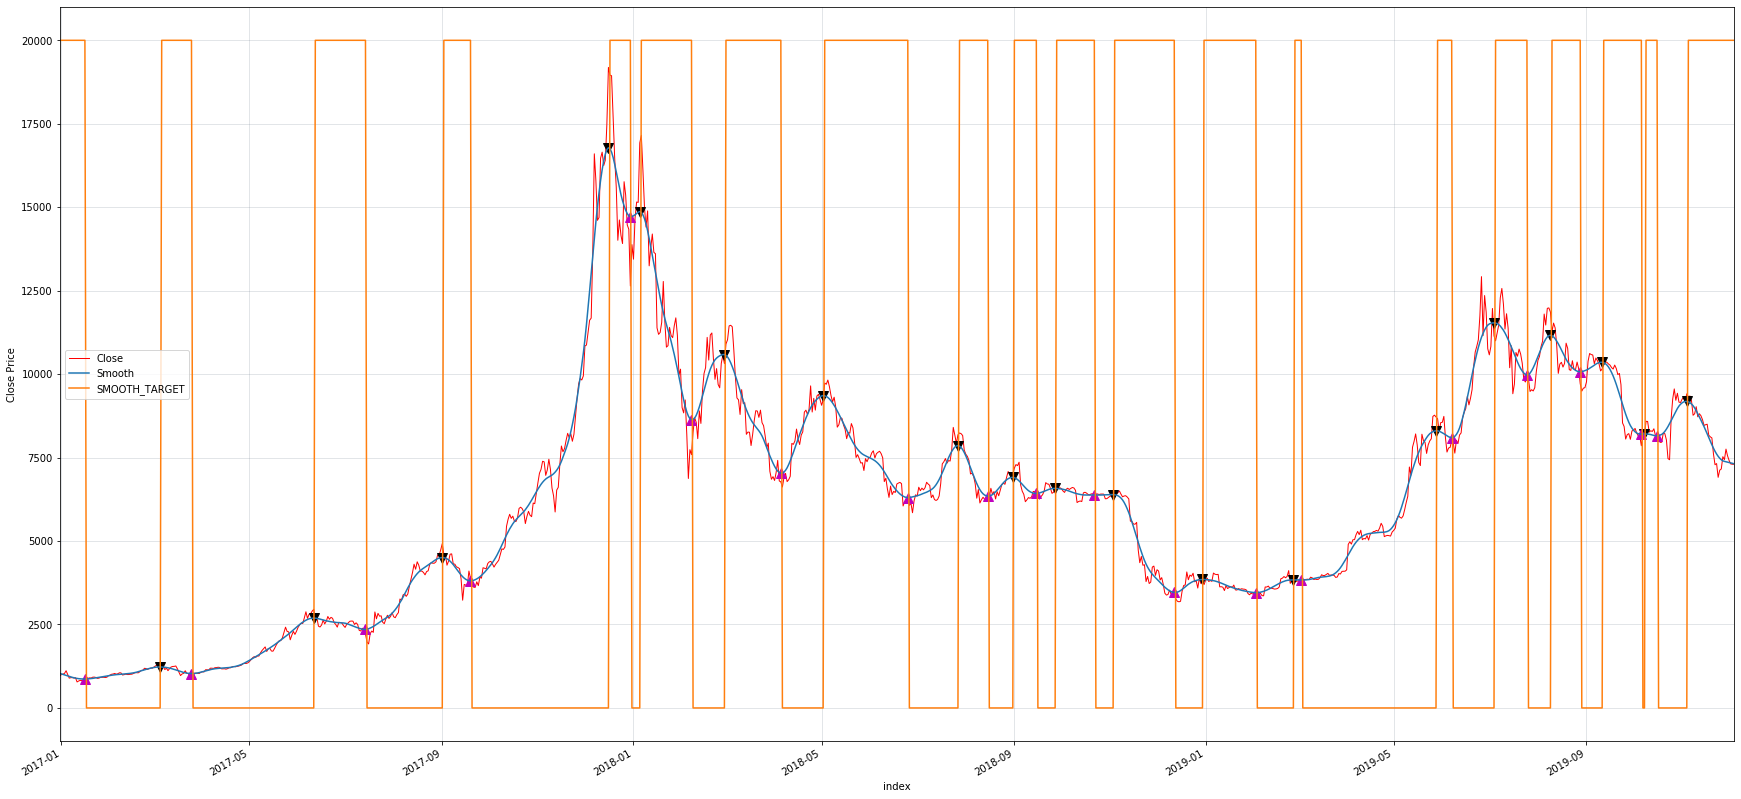

In [30]:
fig = plt.figure(figsize = (30,15))
plt1 = fig.add_subplot(111, ylabel = 'Close Price')

plt1.plot(df.index, df.Close, color = 'red', label = "Close", linewidth = 1.0)

#plt1.plot(signal_df.short_mav[signal_df.positions == -1.0].index, signal_df.short_mav[signal_df.positions == -1], 'v', markersize = 10, color = 'k')
#plt1.plot(signal_df.short_mav[signal_df.positions == 1.0].index, signal_df.short_mav[signal_df.positions == 1], '^', markersize = 10, color = 'm')
plt1.plot(smoothsig.Smooth[smoothsig.signal == -1.0].index, smoothsig.Smooth[smoothsig.signal == -1.0], 'v', markersize = 10, color = 'k')
plt1.plot(smoothsig.Smooth[smoothsig.signal == 1.0].index, smoothsig.Smooth[smoothsig.signal == 1], '^', markersize = 10, color = 'm')

df['Smooth'].plot(figsize=(30,15))
#(20000*df['MAC_TARGET']).plot(figsize=(30,15))
(20000*df['SMOOTH_TARGET']).plot(figsize=(30,15))
#plt.plot(exp.index, (20000*exp[['PRED']]), color = 'green', linewidth = .5)
plt.legend()
plt.grid(alpha = 0.25, color = 'slategray')
plt.show()

# Paper Trade

In [31]:
#daily.head()

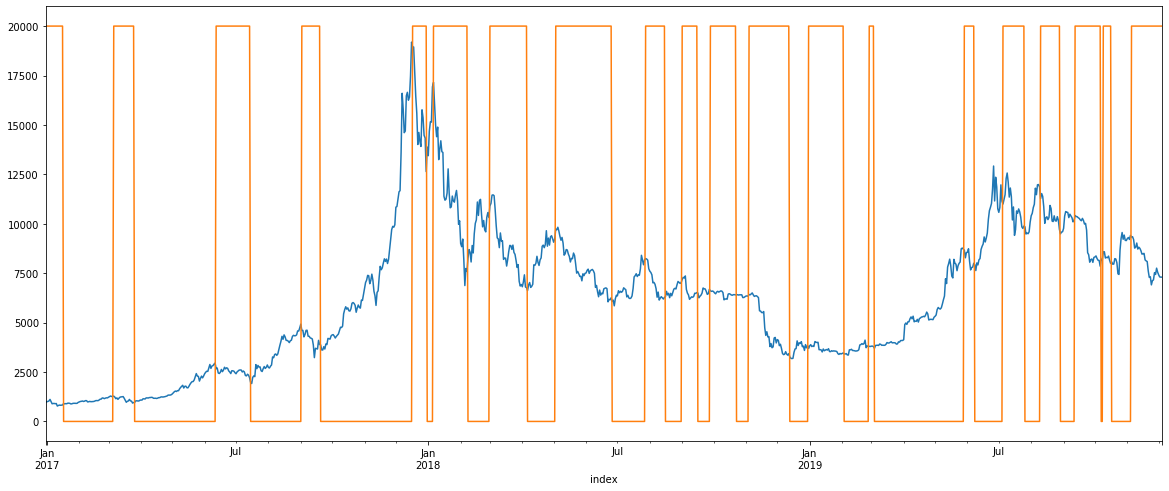

In [32]:
plt.figure(figsize = (20,8))

df['Close'].plot()
(20000*df['SMOOTH_TARGET']).plot()
plt.show()

In [33]:
df['target_region'] = (df.SMOOTH_TARGET != df.SMOOTH_TARGET.shift()).cumsum()
# df['target_region'] = (df.MAC_TARGET != df.MAC_TARGET.shift()).cumsum()

mid_region_days = df.groupby('target_region').apply(lambda x: x.index.tolist()).apply(lambda x: x[int(len(x)//2)]).tolist()
mid_region_days[:5]

[Timestamp('2017-01-08 00:00:00'),
 Timestamp('2017-02-10 00:00:00'),
 Timestamp('2017-03-16 00:00:00'),
 Timestamp('2017-05-04 00:00:00'),
 Timestamp('2017-06-28 00:00:00')]

In [34]:
df.loc[mid_region_days][['Close', 'SMOOTH_TARGET']].diff()[df.SMOOTH_TARGET == 1]#['Close'].sum()
# df.loc[mid_region_days][['Close', 'MAC_TARGET']].diff()[df.MAC_TARGET == 1]#['Close'].sum()

C:\Users\Brandon.Paralititan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Close,SMOOTH_TARGET
index,,
2017-01-08,NaN,NaN
2017-03-16,176.54,1.0
2017-06-28,1022.67,1.0
2017-09-11,794.90,1.0
2017-12-24,7011.05,1.0
2018-01-22,-4346.63,1.0
2018-03-19,-1824.13,1.0
2018-05-30,-895.58,1.0
2018-08-06,692.23,1.0


In [35]:
#mac 7274
#smooth 7178

In [36]:
bsdf = df.copy()
bsdf.head()

,date,Open,High,Low,Close,Volume (BTC),Volume (Currency),slope12,slope26,acc12,...,sgn_region_len,RSI,RSI>70,RSI<30,RSI<20,MA12>MA26,MAC_TARGET,SMOOTH_TARGET,PRED,target_region
index,,,,,,,,,,,,,,,,,,,,,
2016-12-31,736329.0,959.54,966.37,944.11,966.30,4162.921299,3.978648e+06,0.0,0.0,0.0,...,5,0.0,0.0,0.0,0.0,0.0,1,1,1,1
2017-01-01,736330.0,966.34,1005.00,960.53,997.75,6850.593309,6.764742e+06,0.0,0.0,0.0,...,5,0.0,0.0,0.0,0.0,0.0,1,1,1,1
2017-01-02,736331.0,997.75,1032.00,990.01,1012.54,8167.381030,8.273577e+06,0.0,0.0,0.0,...,5,0.0,0.0,0.0,0.0,0.0,1,1,1,1
2017-01-03,736332.0,1011.44,1039.00,999.99,1035.24,9089.658025,9.276500e+06,0.0,0.0,0.0,...,5,0.0,0.0,0.0,0.0,0.0,1,1,1,1
2017-01-04,736333.0,1035.51,1139.89,1028.56,1114.92,21562.456972,2.346964e+07,0.0,0.0,0.0,...,5,0.0,0.0,0.0,0.0,0.0,1,1,1,1


In [37]:
bsdf['predsig'] = bsdf['PRED']-bsdf['PRED'].shift(-1)

In [38]:
bsdf['perfect'] = bsdf['SMOOTH_TARGET'] - bsdf['SMOOTH_TARGET'].shift(-1)

In [39]:
class WeighTarget(bt.Algo):
    """
    Sets target weights based on a target weight DataFrame.

    Args:
        * target_weights (DataFrame): DataFrame containing the target weights

    Sets:
        * weights

    """

    def __init__(self, target_weights):
        self.tw = target_weights

    def __call__(self, target):
        # get target weights on date target.now
        if target.now in self.tw.index:
            w = self.tw.ix[target.now]

            # save in temp - this will be used by the weighing algo
            # also dropping any na's just in case they pop up
            target.temp['weights'] = w.dropna()

        # return True because we want to keep on moving down the stack
        return True

In [40]:
tw = bsdf[['PRED']].fillna(0).rename({'PRED': 'Close'}, axis=1)
tw = 1 - tw

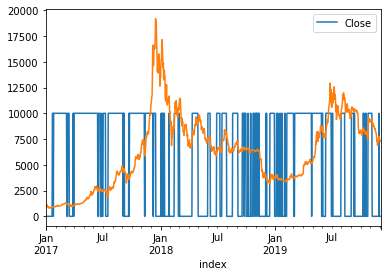

In [41]:
(10000*tw).plot()
bsdf.Close.plot()

In [42]:
tw.head()

,Close
index,
2016-12-31,0
2017-01-01,0
2017-01-02,0
2017-01-03,0
2017-01-04,0


In [43]:
df[['Close']].head()

,Close
index,
2016-12-31,966.30
2017-01-01,997.75
2017-01-02,1012.54
2017-01-03,1035.24
2017-01-04,1114.92


In [44]:
bsdf[['Close']].head()

,Close
index,
2016-12-31,966.30
2017-01-01,997.75
2017-01-02,1012.54
2017-01-03,1035.24
2017-01-04,1114.92


In [45]:
s = bt.Strategy('smooth', [WeighTarget(tw),
                           bt.algos.Rebalance()])

t = bt.Backtest(s, bsdf[['Close']])
# t = bt.Backtest(s, data)
res = bt.run(t)

NameError: name 'WeighTarget' is not defined

In [ ]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
            
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [ ]:
def long_only_ew(data, name='long_only_ew'):
    s = bt.Strategy(name, [bt.algos.RunOnce(),
                           bt.algos.SelectAll(),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])
    data = data
    return bt.Backtest(s, data)

benchmark = long_only_ew(df[['Close']], name='hold')

# run all the backtests!
res2 = bt.run(benchmark)

In [ ]:
res.display()

In [ ]:
res2.display()